In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [3]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
28055,00007317_016.png,Nodule,16,7317,55,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_004/images/00007317_016.png,1.0
91983,00022954_000.png,Nodule,0,22954,24,F,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00022954_000.png,1.0
64283,00015856_001.png,No Finding,1,15856,65,M,PA,2842,2991,0.143,0.143,NaN,../input/data/images_007/images/00015856_001.png,0.0


In [4]:
print('Before sampling...')
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)

print('After sampling...')
all_xray_df = all_xray_df.sample(22000, random_state=25)
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)
all_xray_df.sample(3)

Before sampling...
0.0    60361
1.0    51759
Name: Binary Labels, dtype: int64
After sampling...
0.0    11764
1.0    10236
Name: Binary Labels, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
82392,00020274_008.png,Effusion|Pneumothorax,8,20274,53,F,PA,2282,2777,0.143,0.143,NaN,../input/data/images_009/images/00020274_008.png,1.0
30359,00007916_007.png,Emphysema,7,7916,63,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_004/images/00007916_007.png,1.0
18721,00004969_001.png,No Finding,1,4969,19,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_003/images/00004969_001.png,0.0


In [5]:
images = list(all_xray_df['path'])
labels = list(all_xray_df['Binary Labels'].map(lambda x: [x]))
train_img, val_img, train_label, val_label = train_test_split(images, labels, 
                                   test_size = 0.2, 
                                   random_state = 7,
                                   stratify = labels)
print('train:', len(train_img), '\nvalidation:', len(val_img))

train: 17600 
validation: 4400


In [6]:
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.Linear_layer = nn.Sequential(nn.Linear(2048, 4096), 
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(4096, 2048),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(2048, 1024),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(1024, 512),
                                              nn.ReLU(),
                                              nn.Linear(512, 1))
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        x = self.out(x)
        return x

In [7]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [8]:
model = models.resnet50(pretrained=True)
model = Net(model)
print(model)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Net(
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

In [9]:
train = my_set(train_img, train_label, transform = my_transform)
trainloader = DataLoader(train, batch_size=32, shuffle=True, num_workers = 2)

val = my_set(val_img, val_label, transform = my_transform)
validloader = DataLoader(val, batch_size=32, shuffle=False, num_workers = 2)


valid_loss_min = np.Inf # track change in validation loss
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0002, momentum = 0.9 ,weight_decay=0.00002 )
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0002, weight_decay=0.00002 )
n_epochs = 10

train_ac = []
test_ac = []
t_loss = []
v_loss = []

In [10]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [13]:
def training_loop(model):
    for epoch in tqdm(range(1, n_epochs+1)):
        train_loss = 0.0
        valid_loss = 0.0
        print('running epoch: {}'.format(epoch))
        model.train()
        train_correct = 0
        train_total = 0
        for data, target in trainloader:
            target = target.squeeze(1)
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_total += target.size(0)
            predicted = (output>0.5).float()
            train_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()

        # validate the model
        model.eval()
        valid_correct = 0
        valid_total = 0
        for data, target in validloader:
            target = target.squeeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_total += target.size(0)
            predicted = (output>0.5).float()
            valid_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
        train_ac.append(100 * train_correct / train_total)
        test_ac.append(100 * valid_correct / valid_total) 

        print('Train Loss: {}'.format(train_loss))
        print('Validation Loss: {}'.format(valid_loss))
        print('Train Accuracy: {}'.format(100 * train_correct / train_total))
        print('Validation Accuracy: {}'.format(100 * valid_correct / valid_total))

In [14]:
training_loop(model)

  0%|          | 0/10 [00:00<?, ?it/s]

running epoch: 1


 10%|█         | 1/10 [12:10<1:49:35, 730.62s/it]

Train Loss: 0.6377773248607462
Validation Loss: 0.6280198272791776
Train Accuracy: 65.1875
Validation Accuracy: 66.9090909090909
running epoch: 2


 20%|██        | 2/10 [23:44<1:34:32, 709.08s/it]

Train Loss: 0.6222943223064596
Validation Loss: 0.6310803458907387
Train Accuracy: 66.88636363636364
Validation Accuracy: 65.22727272727273
running epoch: 3


 30%|███       | 3/10 [35:16<1:21:49, 701.34s/it]

Train Loss: 0.6118319640918212
Validation Loss: 0.6588718947497281
Train Accuracy: 68.0909090909091
Validation Accuracy: 66.3409090909091
running epoch: 4


 40%|████      | 4/10 [46:34<1:09:11, 691.90s/it]

Train Loss: 0.6048378930850462
Validation Loss: 0.6279439011487093
Train Accuracy: 68.7215909090909
Validation Accuracy: 66.18181818181819
running epoch: 5


 50%|█████     | 5/10 [57:54<57:19, 687.82s/it]  

Train Loss: 0.6006437464735724
Validation Loss: 0.6086712079698389
Train Accuracy: 68.89204545454545
Validation Accuracy: 68.29545454545455
running epoch: 6


 60%|██████    | 6/10 [1:09:05<45:28, 682.16s/it]

Train Loss: 0.5992793548649008
Validation Loss: 0.6374535593119535
Train Accuracy: 69.32954545454545
Validation Accuracy: 64.5
running epoch: 7


 70%|███████   | 7/10 [1:20:16<33:54, 678.27s/it]

Train Loss: 0.5969360372153195
Validation Loss: 0.615797738161954
Train Accuracy: 69.42045454545455
Validation Accuracy: 67.75
running epoch: 8


 80%|████████  | 8/10 [1:31:36<22:38, 679.07s/it]

Train Loss: 0.5923086776516654
Validation Loss: 0.6151039665395563
Train Accuracy: 69.4034090909091
Validation Accuracy: 67.11363636363636
running epoch: 9


 90%|█████████ | 9/10 [1:42:57<11:19, 679.55s/it]

Train Loss: 0.5883203122832559
Validation Loss: 0.6127864180911671
Train Accuracy: 69.73863636363636
Validation Accuracy: 67.5909090909091
running epoch: 10


100%|██████████| 10/10 [1:54:20<00:00, 686.08s/it]

Train Loss: 0.5882132770256563
Validation Loss: 0.6077275076779453
Train Accuracy: 70.2840909090909
Validation Accuracy: 67.93181818181819


In [21]:
test_correct = 0
test_total = 0
pred_label = []
pred_for_roc_curve = []
for data, target in validloader:
    target = target.squeeze(1)
    data, target = data.to(device), target.to(device)
    out = model(data)
    predicted = (out>0.5).float()
    pred_label.extend(predicted.tolist())
    pred_for_roc_curve.extend(out.tolist())
    test_correct += (predicted == target).sum().item()
    test_total += target.size(0)
    del data
    gc.collect()
    torch.cuda.empty_cache()
print('Testing Auccracy: {}'.format((100 * test_correct / test_total)))
acu = (100 * test_correct / test_total)

Testing Auccracy: 68.5


In [23]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
model_confusion_matrix = confusion_matrix(val_label, pred_label)
model_confusion_matrix

array([[1679,  674],
       [ 712, 1335]])

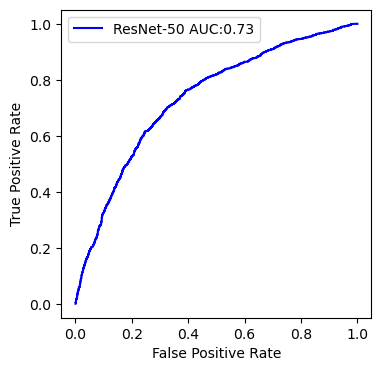

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score as acc
fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
fpr, tpr, thresholds = roc_curve(val_label, pred_for_roc_curve)
c_ax.plot(fpr, tpr, color='blue', label = 'ResNet-50 AUC:%0.2f'  % (auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig("plot1.png")

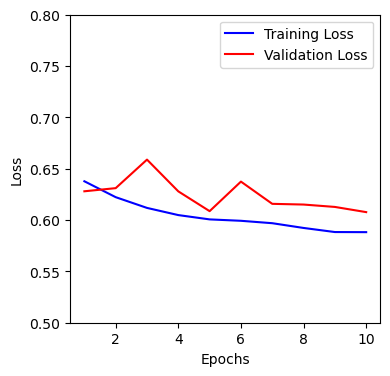

In [33]:
fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_xlabel('Epochs')
plt.ylim([0.5, 0.8])
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")